In [72]:
#importing libraries 
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
import skbio
import skbio.diversity
import skbio.stats.composition
import scipy
import pylab as pl
import statsmodels.api as sm
# import statsmodels as sm
from statsmodels.formula.api import ols
from functools import reduce
from scipy import stats


from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn import model_selection
from string import ascii_letters
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV,LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression



%matplotlib inline

import arivale_data_interface as adi
# apply settings so the lib knows where the data is
adi.apply_isb_config()

#list the local snapshots
local_snapshots = adi.list_local_snapshots()
print(len(local_snapshots))
local_snapshots[0]

# ignore deprecation warnings
import warnings
warnings.filterwarnings('ignore')

98


In [73]:
#read in samples metadata
samples = pd.read_csv("/proj/arivale/microbiome/16S_processed/metadata.csv")

#load in metabolomics snapshot
metabolomics = adi.get_snapshot('metabolomics_corrected')
metabolomics_metadata = adi.get_snapshot('metabolomics_metadata')

#load in medications_assessments snapshot 
medications = adi.get_snapshot('assessments_medications')
#only include patients who have not taken antibiotics in the last three months 
no_antibiotics = medications[medications['meds_antibiotics_last_3_months'].isin(['No'])]

In [74]:
# view head size of dataframe containing all samples
all_samples = samples.copy(deep=True)
all_samples_ids = all_samples['id'].values
all_samples.head()
all_samples.shape

(5232, 24)

In [75]:
# filtering for age and antibiotic use and collecting baseline samples

#merge samples with antibiotics data
samples_noab = pd.merge(all_samples,no_antibiotics[['public_client_id',
                                                           'meds_antibiotics_last_3_months',]],on='public_client_id')

#filter out ages in the outside range
samples_over35 = samples_noab[samples_noab['age'] >=0]
age_filtered_samples = samples_over35[samples_over35['age'] <= 65]
age_filtered_samples.shape

#filter for checkpoint1 samples (45 days or less)
baseline_samples = age_filtered_samples.copy(deep=True)
baseline_samples['days_since_first_draw_abs'] = baseline_samples['days_since_first_draw'].abs()
baseline_samples = baseline_samples[baseline_samples['days_since_first_draw'].abs() <= 45]
ckpt1_samples = baseline_samples.sort_values('days_since_first_draw_abs').groupby('public_client_id').first()
dups = baseline_samples.pivot_table(index = ['public_client_id'], aggfunc = 'size')
ckpt1_samples

,genome_id,genome_vendor,multiple_genome_ids,client_id,user_id,sex,race,has_research_consent,enterprise,coach,...,age,vendor_observation_id,days_in_program,days_since_first_call,days_since_first_draw,month,weekday,id,meds_antibiotics_last_3_months,days_since_first_draw_abs
public_client_id,,,,,,,,,,,,,,,,,,,,,
01000261,A477AV494-007,NEXTCODE,NaN,1966.0,641b9f5d-2625-453d-8a89-d1a8bd9e77a6,F,NaN,True,d4cd0dabcf4caa22,NaN,...,49.0,AV15-1592,77.0,3.0,12.0,Jan,Sun,AV15-1592|AKE013,No,12.0
01001298,DS-309044,WUXI_SNP,NaN,275178.0,927b5bbb-906a-4069-a268-878eb70fbf14,F,white,True,291e3ca0f5102f9e,NaN,...,61.0,22001805511243,16.0,9.0,9.0,Sep,Thu,22001805511243|GFM-1079-033,No,9.0
01001661,DS-268028,NEXTCODE,NaN,177541.0,359bbe84-565d-4892-bce9-4a7432f8ae40,F,east asian,True,f89affb34da2473b,NaN,...,30.0,22001612561628,20.0,6.0,-4.0,Jun,Mon,22001612561628|GFM-1079-008,No,4.0
01002412,A294AU436-007,NEXTCODE,NaN,2089.0,6b59004d-4d77-4d96-b030-567e708bd3ad,F,white,True,d4cd0dabcf4caa22,NaN,...,52.0,AV15-1446,13.0,-6.0,0.0,Nov,Thu,AV15-1446|AKE010,No,0.0
01002471,DS-267561,NEXTCODE,NaN,171234.0,dca059f2-2bc4-4de2-a992-baeb01e01de7,F,white,True,ce0cf55cf4a60dd0,NaN,...,55.0,22001612560274,74.0,48.0,33.0,Jun,Mon,22001612560274|GFM-1079-008,No,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HX970715,DS-298885,WUXI_SNP,NaN,200025.0,e720a495-b4e7-47d4-bdf9-fc737c1a25df,M,white,True,4e4c6b2a9f589c92,NaN,...,57.0,22001803513129,170.0,121.0,-1.0,Apr,Thu,22001803513129|GFM-1079-024,No,1.0
JFOM,NaN,NaN,NaN,555.0,68eefee4-e773-4083-a250-2156fc7a37c6,F,asian,True,d4cd0dabcf4caa22,NaN,...,49.0,AV15-1243,0.0,102.0,0.0,Oct,Mon,AV15-1243|AKE010,No,0.0
ZU273983,DS-347527,WUXI_SNP,NaN,237509.0,6f267e77-77eb-4b4b-8f6c-12124d32fe79,F,white,True,aac0298a21469db8,NaN,...,32.0,22001805510979,9.0,287.0,8.0,Dec,Fri,22001805510979|GFM-1079-038,No,8.0


In [76]:
# converting metabolite id's to chemical names and pathways

metabolites = pd.DataFrame()
metabolites_in_use = pd.DataFrame()
metabolites_in_use['chemid'] = metabolomics.columns[8:].astype(int)
 

metabolites['metabolites'] = metabolomics_metadata['SUB_PATHWAY'] + ', ' + metabolomics_metadata['SUPER_PATHWAY'] + ', ' + metabolomics_metadata['BIOCHEMICAL_NAME']
metabolites = metabolites.replace(np.nan, 'Unannotated metabolite X')
metabolites['chemid'] = metabolomics_metadata['CHEMICAL_ID']
metabolites_measured = metabolites.merge(metabolites_in_use, how='inner', on='chemid')


mapping_dict = dict(zip(metabolites_measured.chemid.astype(str), metabolites_measured.metabolites))
metabolites_alone = metabolomics.iloc[:, 8:]
metabolites_meta = metabolomics.iloc[:, 0:8]
metabolites_alone = metabolites_alone.rename(columns=mapping_dict)

metabolomics = pd.concat([metabolites_meta, metabolites_alone], axis=1)
metabolomics

,public_client_id,sample_id,days_in_program,days_since_first_call,days_since_first_draw,month,weekday,season,"Glutamate Metabolism, Amino Acid, S-1-pyrroline-5-carboxylate","Polyamine Metabolism, Amino Acid, spermidine",...,Unannotated metabolite X,Unannotated metabolite X,Unannotated metabolite X,Unannotated metabolite X,Unannotated metabolite X,Unannotated metabolite X,Unannotated metabolite X,Unannotated metabolite X,Unannotated metabolite X,Unannotated metabolite X
0,01000261,A477AV558-002,65,-9.0,0,Jan,Tue,winter,0.972222,2.568898,...,1.045152,0.592175,0.437347,0.615018,0.923405,1.106525,1.129321,1.136554,0.376786,NaN
1,01001621,A391BM948-002,265,223.0,254,Apr,Wed,spring,1.819302,0.704097,...,NaN,0.737648,1.109209,0.391366,0.844609,NaN,NaN,NaN,NaN,NaN
2,01001621,A776BI445-003,11,-31.0,0,Jul,Mon,summer,2.540378,0.568236,...,2.198704,1.036609,2.861960,0.980013,1.245966,NaN,NaN,NaN,NaN,NaN
3,01002183,A595AV320-002,13,-1.0,0,Jan,Wed,winter,0.528804,2.260729,...,0.772146,3.109291,1.689441,0.923594,0.896029,0.915957,0.859884,0.862706,0.364450,0.932469
4,01002412,A294AU415-002,13,-6.0,0,Nov,Thu,fall,0.863152,0.535317,...,0.725215,1.702258,1.155391,1.151021,NaN,0.913408,0.886259,NaN,0.214291,0.639387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3300,HX409129,A581BK409-002,5,2.0,0,Dec,Fri,winter,0.293945,1.169026,...,0.271015,NaN,NaN,0.490163,NaN,NaN,NaN,NaN,NaN,0.943314
3301,HX460562,A641BO324-003,28,7.0,0,Aug,Thu,summer,0.967099,1.137992,...,1.027760,0.947308,NaN,NaN,1.123345,NaN,NaN,NaN,NaN,0.854447
3302,HX794171,A229BM682-002,56,-17.0,0,Mar,Fri,spring,0.847237,0.739835,...,1.733623,0.935738,NaN,0.498029,NaN,NaN,NaN,NaN,NaN,1.124675
3303,INEW,A750AX220-002,149,106.0,142,Mar,Fri,spring,NaN,2.187877,...,NaN,1.161242,1.508146,0.564052,0.629977,1.058272,1.246964,1.205722,0.756568,0.629693


In [77]:
# new_metabolomics = metabolomics.copy(deep=True)
# new_metabolomics.set_index(new_metabolomics['public_client_id'], inplace=True)
# new_metabolomics = new_metabolomics.iloc[:, 8:]

# normalized_metabolomics = new_metabolomics.apply(lambda x: np.log(x) - (np.log(x).mean()), axis=1)
# normalized_metabolomics


In [78]:
pre_corr_ = adi.get_snapshot('metabolomics_samples')
pre_corr_

,public_client_id,sample_id,days_in_program,days_since_first_call,days_since_first_draw,month,weekday,season,BATCH_DATE,BATCH_ID_209,...,NUM_METABOLITES_209,NUM_METABOLITES_305,NUM_METABOLITES_400,NUM_METABOLITES_402,RATIO_METABOLITES_209,RATIO_METABOLITES_305,RATIO_METABOLITES_400,RATIO_METABOLITES_402,NUM_CONTROLS,NUM_UNNORMALIZED_METABOLITES
0,01000261,A477AV558-002,65,-9.0,0,Jan,Tue,winter,2016-05-27,80286,...,539,54,242,284,1.100409,1.145138,1.168311,1.087748,4,30
1,01001621,A776BI445-003,11,-31.0,0,Jul,Mon,summer,2018-06-15,128393,...,410,46,188,265,0.837046,0.975488,0.907613,1.014976,16,43
2,01001621,A391BM948-002,265,223.0,254,Apr,Wed,spring,2018-06-15,128549,...,481,46,178,266,0.981998,0.975488,0.859336,1.018806,16,43
3,01002183,A595AV320-002,13,-1.0,0,Jan,Wed,winter,2016-05-27,80286,...,535,53,246,283,1.092243,1.123932,1.187622,1.083918,4,30
4,01002412,A294AU415-002,13,-6.0,0,Nov,Thu,fall,2016-05-27,80081,...,514,47,238,272,1.049370,0.996695,1.149000,1.041787,4,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3285,HX409129,A581BK409-002,5,2.0,0,Dec,Fri,winter,2019-03-04,146456,...,442,45,193,262,0.902376,0.954282,0.931752,1.003486,12,27
3286,HX460562,A641BO324-003,28,7.0,0,Aug,Thu,summer,2019-03-04,146456,...,462,53,206,244,0.943208,1.123932,0.994512,0.934544,12,27
3287,HX794171,A229BM682-002,56,-17.0,0,Mar,Fri,spring,2019-03-04,146456,...,464,49,196,261,0.947291,1.039107,0.946235,0.999656,12,27
3288,INEW,A750AX220-002,149,106.0,142,Mar,Fri,spring,2016-05-27,80181,...,552,51,243,280,1.126950,1.081520,1.173139,1.072428,2,28


In [79]:
batch_info = pre_corr_[['public_client_id', 'sample_id', 'BATCH_DATE']]

date_list = ['2016-05-27', '2016-09-14', '2017-04-13', '2017-12-14', '2018-03-22', '2018-06-15', '2018-09-28', '2018-10-31', '2019-01-18', '2019-03-04', '2019-11-21']
batch_number_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
batch_number_map = dict(zip(date_list, batch_number_list))

batch_info['batch_number'] = batch_info['BATCH_DATE'].map(batch_number_map)
batch_info

,public_client_id,sample_id,BATCH_DATE,batch_number
0,01000261,A477AV558-002,2016-05-27,0
1,01001621,A776BI445-003,2018-06-15,5
2,01001621,A391BM948-002,2018-06-15,5
3,01002183,A595AV320-002,2016-05-27,0
4,01002412,A294AU415-002,2016-05-27,0
...,...,...,...,...
3285,HX409129,A581BK409-002,2019-03-04,9
3286,HX460562,A641BO324-003,2019-03-04,9
3287,HX794171,A229BM682-002,2019-03-04,9
3288,INEW,A750AX220-002,2016-05-27,0


In [80]:
metabolomics_batches = pd.merge(metabolomics, batch_info, how='inner', on=['public_client_id','sample_id'])
metabolomics_batches

cutoff = 0.1

feat_metabs = metabolomics_batches.iloc[:, 8:1305]
no_use_metabs = feat_metabs.columns[feat_metabs.isnull().mean()>cutoff]
metabolomics_batches = metabolomics_batches.drop(no_use_metabs, axis=1)
metabolomics_batches = metabolomics_batches.fillna(0)
print('removing', len(no_use_metabs), 'features from metabolomics')
metabolomics_batches

removing 580 features from metabolomics


,public_client_id,sample_id,days_in_program,days_since_first_call,days_since_first_draw,month,weekday,season,"Nicotinate and Nicotinamide Metabolism, Cofactors and Vitamins, 1-methylnicotinamide","TCA Cycle, Energy, alpha-ketoglutarate",...,"Partially Characterized Molecules, Partially Characterized Molecules, bilirubin degradation product, C17H18N2O4 (2)**","Partially Characterized Molecules, Partially Characterized Molecules, bilirubin degradation product, C17H18N2O4 (3)**","Partially Characterized Molecules, Partially Characterized Molecules, bilirubin degradation product, C17H20N2O5 (1)**","Partially Characterized Molecules, Partially Characterized Molecules, bilirubin degradation product, C17H20N2O5 (2)**","Corticosteroids, Lipid, tetrahydrocortisol glucuronide","Modified Peptides, Peptide, N,N-dimethyl-pro-pro","Chemical, Xenobiotics, oxindolylalanine","Corticosteroids, Lipid, tetrahydrocortisone glucuronide (5)",BATCH_DATE,batch_number
0,01000261,A477AV558-002,65,-9.0,0,Jan,Tue,winter,1.155771,0.947589,...,1.007758,0.923649,1.234996,1.212362,1.755080,1.215912,0.875767,1.578019,2016-05-27,0
1,01001621,A391BM948-002,265,223.0,254,Apr,Wed,spring,0.619724,1.334809,...,0.549279,0.534946,0.990487,1.023327,0.590899,1.104918,1.069461,0.720663,2018-06-15,5
2,01001621,A776BI445-003,11,-31.0,0,Jul,Mon,summer,1.328050,1.366908,...,0.305781,0.283538,0.169974,0.186747,0.838416,0.983485,1.125988,0.480528,2018-06-15,5
3,01002183,A595AV320-002,13,-1.0,0,Jan,Wed,winter,0.425073,0.850577,...,1.483916,1.490669,2.188782,2.242122,1.005220,1.496028,0.400337,0.903502,2016-05-27,0
4,01002412,A294AU415-002,13,-6.0,0,Nov,Thu,fall,1.008430,0.877139,...,1.045247,1.019456,0.799052,0.849979,1.158250,0.942423,0.568667,0.783065,2016-05-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3276,HX409129,A581BK409-002,5,2.0,0,Dec,Fri,winter,2.116840,0.000000,...,1.039706,1.127532,0.000000,1.143456,0.868019,0.000000,0.729041,0.699870,2019-03-04,9
3277,HX460562,A641BO324-003,28,7.0,0,Aug,Thu,summer,1.731506,0.804149,...,0.620436,0.636034,1.029785,0.861696,1.412587,0.698305,0.912816,1.319646,2019-03-04,9
3278,HX794171,A229BM682-002,56,-17.0,0,Mar,Fri,spring,0.660610,0.000000,...,1.210282,1.189631,2.346108,1.882730,1.068692,0.964132,0.000000,1.455387,2019-03-04,9
3279,INEW,A750AX220-002,149,106.0,142,Mar,Fri,spring,1.635473,0.826271,...,0.492534,0.472812,0.359782,0.382403,1.856882,0.000000,1.126530,0.000000,2016-05-27,0


<AxesSubplot:xlabel='Nicotinate and Nicotinamide Metabolism, Cofactors and Vitamins, 1-methylnicotinamide', ylabel='Count'>

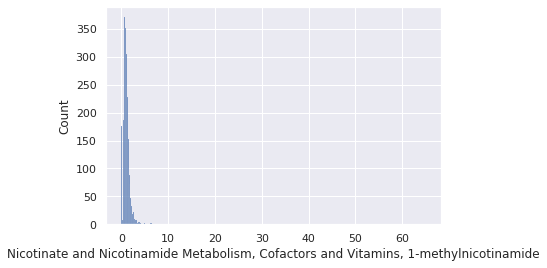

In [81]:
sns.histplot(metabolomics_batches['Nicotinate and Nicotinamide Metabolism, Cofactors and Vitamins, 1-methylnicotinamide'], bins=500)

In [82]:
# creating a function that performs the normalization
def normalize(number):
    # median = median of log of the series that the number is in
    median = (np.log(number + 1e-6).median(axis=0))
    # take the log of each value in each row
    number = np.log(number + 1e-6)
    return number - median


batches = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
batch_dfs = {}
batch_list = []
batch = pd.DataFrame()

# for each batch number
for x in batches:
    # set batch equal to the entire dataframe that only contains samples from the same batch
    batch = metabolomics_batches.loc[metabolomics_batches['batch_number'] == x]
    # append the batch dataframe to the list
    batch_dfs[x] = batch

df_0 = pd.DataFrame(batch_dfs['0'])
df_1 = pd.DataFrame(batch_dfs['1'])
df_2 = pd.DataFrame(batch_dfs['2'])
df_3 = pd.DataFrame(batch_dfs['3'])
df_4 = pd.DataFrame(batch_dfs['4'])
df_5 = pd.DataFrame(batch_dfs['5'])
df_6 = pd.DataFrame(batch_dfs['6'])
df_7 = pd.DataFrame(batch_dfs['7'])
df_8 = pd.DataFrame(batch_dfs['8'])
df_9 = pd.DataFrame(batch_dfs['9'])
df_10 = pd.DataFrame(batch_dfs['10'])

# because i can't figure out how to make the nested for loops or the
# lambda function/groupby work instead im making a new loop for each batch

# make a copy of the batch dataframe so that it's not modified
norm_batch_0 = df_0.copy(deep=True)
# only look at the columns containing metabolites
for k in df_0.iloc[:, 8:624]:
    # apply the function on all columns one at a time and assign normalized values
    norm_batch_0[[k]] = df_0[[k]].apply(normalize)
    
norm_batch_1 = df_1.copy(deep=True)
for k in df_1.iloc[:, 8:624]:
    norm_batch_1[[k]] = df_1[[k]].apply(normalize)
    
norm_batch_2 = df_2.copy(deep=True)
for k in df_2.iloc[:, 8:624]:
    norm_batch_2[[k]] = df_2[[k]].apply(normalize)
    
norm_batch_3 = df_3.copy(deep=True)
for k in df_3.iloc[:, 8:624]:
    norm_batch_3[[k]] = df_3[[k]].apply(normalize)
    
norm_batch_4 = df_4.copy(deep=True)
for k in df_4.iloc[:, 8:624]:
    norm_batch_4[[k]] = df_4[[k]].apply(normalize)
    
norm_batch_5 = df_5.copy(deep=True)
for k in df_5.iloc[:, 8:624]:
    norm_batch_5[[k]] = df_5[[k]].apply(normalize)
    
norm_batch_6 = df_6.copy(deep=True)
for k in df_6.iloc[:, 8:624]:
    norm_batch_6[[k]] = df_6[[k]].apply(normalize)
    
norm_batch_7 = df_7.copy(deep=True)
for k in df_7.iloc[:, 8:624]:
    norm_batch_7[[k]] = df_7[[k]].apply(normalize)
    
norm_batch_8 = df_8.copy(deep=True)
for k in df_8.iloc[:, 8:624]:
    norm_batch_8[[k]] = df_8[[k]].apply(normalize)
    
norm_batch_9 = df_9.copy(deep=True)
for k in df_9.iloc[:, 8:624]:
    norm_batch_9[[k]] = df_9[[k]].apply(normalize)
    
norm_batch_10 = df_10.copy(deep=True)
for k in df_10.iloc[:, 8:624]:
    norm_batch_10[[k]] = df_10[[k]].apply(normalize)
    
normalized_dfs = [norm_batch_0, norm_batch_1, norm_batch_2, norm_batch_3, norm_batch_4, norm_batch_5, norm_batch_6, norm_batch_7, norm_batch_8, norm_batch_9, norm_batch_10]

batch_normalized_metabolomics = pd.concat(normalized_dfs)
batch_normalized_metabolomics = batch_normalized_metabolomics.sort_index()
batch_normalized_metabolomics.to_csv('metabolomics_batch_normalized.csv')


batch_normalized_metabolomics

,public_client_id,sample_id,days_in_program,days_since_first_call,days_since_first_draw,month,weekday,season,"Nicotinate and Nicotinamide Metabolism, Cofactors and Vitamins, 1-methylnicotinamide","TCA Cycle, Energy, alpha-ketoglutarate",...,"Partially Characterized Molecules, Partially Characterized Molecules, bilirubin degradation product, C17H18N2O4 (2)**","Partially Characterized Molecules, Partially Characterized Molecules, bilirubin degradation product, C17H18N2O4 (3)**","Partially Characterized Molecules, Partially Characterized Molecules, bilirubin degradation product, C17H20N2O5 (1)**","Partially Characterized Molecules, Partially Characterized Molecules, bilirubin degradation product, C17H20N2O5 (2)**","Corticosteroids, Lipid, tetrahydrocortisol glucuronide","Modified Peptides, Peptide, N,N-dimethyl-pro-pro","Chemical, Xenobiotics, oxindolylalanine","Corticosteroids, Lipid, tetrahydrocortisone glucuronide (5)",BATCH_DATE,batch_number
0,01000261,A477AV558-002,65,-9.0,0,Jan,Tue,winter,0.166316,-0.121071,...,-0.066329,-0.137008,0.110296,0.060543,0.472008,0.137977,-0.006453,0.392246,2016-05-27,0
1,01001621,A391BM948-002,265,223.0,254,Apr,Wed,spring,-0.488833,0.258356,...,-0.478607,-0.545314,-0.000181,0.054355,-0.452170,0.161674,0.010012,-0.244453,2018-06-15,5
2,01001621,A776BI445-003,11,-31.0,0,Jul,Mon,summer,0.273358,0.282119,...,-1.064341,-1.180131,-1.762724,-1.646700,-0.102302,0.045251,0.061518,-0.649738,2018-06-15,5
3,01002183,A595AV320-002,13,-1.0,0,Jan,Wed,winter,-0.833944,-0.229077,...,0.320628,0.341640,0.682573,0.675395,-0.085299,0.345296,-0.789246,-0.165400,2016-05-27,0
4,01002412,A294AU415-002,13,-6.0,0,Nov,Thu,fall,0.029942,-0.198327,...,-0.029803,-0.038316,-0.325101,-0.294571,0.056404,-0.116819,-0.438259,-0.308463,2016-05-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3276,HX409129,A581BK409-002,5,2.0,0,Dec,Fri,winter,0.825628,-13.812032,...,0.145845,0.201536,-13.834114,0.158560,-0.113433,-13.779082,-0.237221,-0.503896,2019-03-04,9
3277,HX460562,A641BO324-003,28,7.0,0,Aug,Thu,summer,0.624695,-0.214491,...,-0.370425,-0.370998,0.010748,-0.124348,0.373531,-0.322669,-0.012417,0.130327,2019-03-04,9
3278,HX794171,A229BM682-002,56,-17.0,0,Mar,Fri,spring,-0.338888,-13.812032,...,0.297760,0.255148,0.834155,0.657228,0.094544,-0.000097,-13.736708,0.228236,2019-03-04,9
3279,INEW,A750AX220-002,149,106.0,142,Mar,Fri,spring,0.513479,-0.258069,...,-0.782247,-0.806640,-1.123027,-1.093307,0.528392,-13.873029,0.245344,-13.879435,2016-05-27,0


In [83]:
baseline_metabolomics_normalized = batch_normalized_metabolomics.copy(deep=True)
baseline_metabolomics_normalized = batch_normalized_metabolomics[batch_normalized_metabolomics['days_since_first_draw'].abs() <= 45]
baseline_metabolomics_normalized.to_csv('baseline_metabolomics_normalized.csv')
print(baseline_metabolomics_normalized.shape)

(2025, 626)


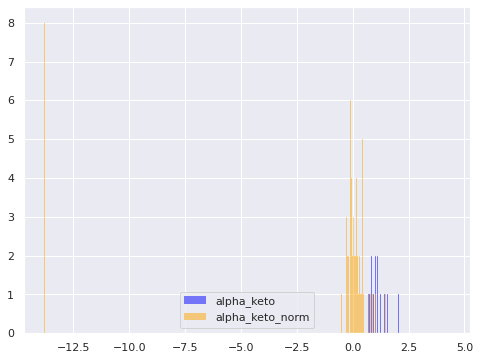

In [84]:
alpha_keto = df_9['TCA Cycle, Energy, alpha-ketoglutarate']
alpha_keto_norm = norm_batch_9['TCA Cycle, Energy, alpha-ketoglutarate']

plt.figure(figsize=(8, 6))
plt.hist(alpha_keto, bins=500, alpha = 0.5, color = 'blue', lw=0, label='alpha_keto');
plt.hist(alpha_keto_norm, bins=500, alpha = 0.5, color = 'orange', lw=0, label='alpha_keto_norm');
plt.xscale=('log')
plt.legend()

<AxesSubplot:ylabel='Frequency'>

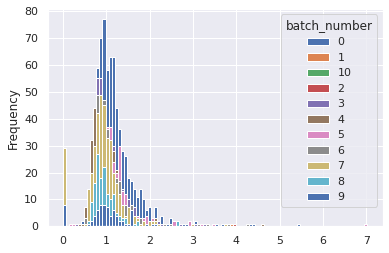

In [85]:
metabolomics_batches.pivot(columns='batch_number', values='TCA Cycle, Energy, alpha-ketoglutarate').plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

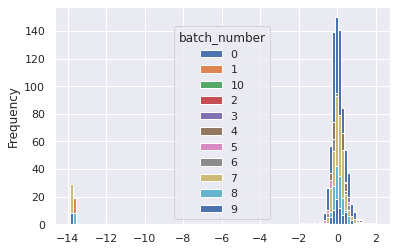

In [86]:
batch_normalized_metabolomics.pivot(columns='batch_number', values='TCA Cycle, Energy, alpha-ketoglutarate').plot.hist(bins=100)

In [87]:
features = metabolomics_batches.columns[8:624].to_list()

# metabolomics_corrected = pd.DataFrame()
# for x in features:
#     if metabolomics_batches[['batch_number']] == 0:
#         metabolomics_corrected[x] = metabolomics_batches[x]

batches = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

batch = pd.DataFrame()

for x in batches:
    batch = metabolomics_batches.loc[metabolomics_batches['batch_number'] == x]
    median_values = []
    for features in batch.iloc[:, 8:624].values:
        median_values.append(np.median(features))
        
    print('batch', x, 'average median =', np.mean(median_values), '; standard dev =', np.std(median_values))

batch 0 average median = 1.0389111983779227 ; standard dev = 0.1090560539796524
batch 1 average median = 0.9295755581909733 ; standard dev = 0.11628081881341082
batch 2 average median = 0.9833687144486106 ; standard dev = 0.07929584300867036
batch 3 average median = 0.9665315274031551 ; standard dev = 0.10853227433468408
batch 4 average median = 0.9556675471284667 ; standard dev = 0.10623972404569311
batch 5 average median = 0.9557188898325208 ; standard dev = 0.10668824230004441
batch 6 average median = 0.9548370226766274 ; standard dev = 0.08841619693514699
batch 7 average median = 0.9386629428483215 ; standard dev = 0.10391039489878183
batch 8 average median = 0.9615085365497923 ; standard dev = 0.08366503860972495
batch 9 average median = 0.9438369011334158 ; standard dev = 0.1381137941558696
batch 10 average median = 0.9706014501082425 ; standard dev = 0.09018854001372767


In [88]:
normal_features = batch_normalized_metabolomics.columns[8:624].to_list()

batches = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

batch = pd.DataFrame()

for x in batches:
    batch = batch_normalized_metabolomics.loc[batch_normalized_metabolomics['batch_number'] == x]
    median_values = []
    for normal_features in batch.iloc[:, 8:624].values:
        median_values.append(np.median(normal_features))
        
    print('batch', x, 'average median =', np.mean(median_values), '; standard dev =', np.std(median_values))

batch 0 average median = -0.018656910606237368 ; standard dev = 0.5136323133722802
batch 1 average median = -0.08035342311915598 ; standard dev = 1.0287740019671467
batch 2 average median = 0.00113338261987963 ; standard dev = 0.07462857869600764
batch 3 average median = -0.0020943963890373537 ; standard dev = 0.11430712658922904
batch 4 average median = -0.0323282626264733 ; standard dev = 0.6702616588811675
batch 5 average median = -0.009952330103327845 ; standard dev = 0.17723800841084608
batch 6 average median = -0.0014328059292758732 ; standard dev = 0.0943517314505674
batch 7 average median = -0.03513417874474806 ; standard dev = 0.7013765538842456
batch 8 average median = -0.001445763684883115 ; standard dev = 0.08518966893908891
batch 9 average median = -0.17771385941712256 ; standard dev = 1.5474299451971563
batch 10 average median = 0.002744272172472081 ; standard dev = 0.08874564652166492


In [89]:
# these are all just blocks of code that i tried to get to work but never could fully lol




# new_values = np.log(old_values + 1e-6) - median(np.log(old_values + 1e-6))

# for x in batches:
#     batch = metabolomics_batches.loc[metabolomics_batches['batch_number'] == x]





# metabolomics_alone = metabolomics_batches.iloc[:, 8:624]


# batch = pd.DataFrame()
# batch_frame = pd.DataFrame()

# batches = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

# def batch_normalize(batches):
    
#     batch_frame = pd.DataFrame()

#     for x in batches:
#         batch = metabolomics_batches.loc[metabolomics_batches['batch_number'] == x]
        
#         print(batch)
        
#         norm_values = []
#         for k in batch.iloc[:, 8:624]:
#             norm_values = np.log(batch[k] + 1e-6) - np.median(np.log(batch[k] + 1e-6))
            
#             norm_values = norm_values.groupby(norm_values.index).sum()
#             batch_frame = pd.concat([batch_frame, norm_values], axis=1)
            
#             # df.groupby("batch_number").apply(single_batch)
            
# #             print(norm_values.head(n=5))
            
#     #         print(batch_frame)
#     #         batch_frame = pd.concat(norm_values, axis=1)
#     #         print(norm_values)
# #         print('batch', x, 'average median =', np.mean(median_values), '; standard dev =', np.std(median_values))
        
# batch_normalize(batches)


#######################################################################################################
#######################################################################################################
#######################################################################################################


# batches = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

# for x in batches:
#     for k in metabolomics_batches.iloc[:, 8:624]:
#         for j in metabolomics_batches.iloc[:, 8:624].values:
#             j = np.log(j + 1e-6) - np.median(np.log(k + 1e-6))
            
# metabolomics_batches


#######################################################################################################
#######################################################################################################
#######################################################################################################



# for k in metabolomics_batches.iloc[:, 8:624]:
#     corrected = (metabolomics_batches.groupby(lambda x: x.batch_number).transform(lambda x: np.log(k + 1e-6) - np.median(np.log(x + 1e-6))))
    
# corrected



#######################################################################################################
#######################################################################################################
#######################################################################################################




# batches = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    

# for x in batches:   
#     for k in metabolomics_batches.iloc[:, 8:624]:
#         print(k)
#         if metabolomics_batches['batch_number'].isin([x]):
#             metabolomics_corrected = metabolomics_batches.apply(lambda k: np.log(k + 1e-6) - np.median(np.log(x + 1e-6)))
# #         metabolomics_corrected = metabolomics_batches.apply(lambda k: np.log(k + 1e-6) - np.median(np.log(x + 1e-6)), axis=0)
        
# print(metabolomics_corrected)


#######################################################################################################
#######################################################################################################
#######################################################################################################


# normal_batch = batch
# corrected = pd.DataFrame()
# normal_batches = []

# # iterate through batch_list, which is a list of all the batches
# for batch_df in batch_list:
#     print(batch_df)
    
#     # for each metabolite in a given batch...
#     for k in batch_df[:, 8:624]:
        
#         # set the values in each column equal to the transformed values
#         normal_batch[[k]] = batch[[k]].apply(normalize)
#         # here i want to re-join all of the modified batched
#         normal_batches.append(normal_batch)



# list_of_cols = []
# for col in metabolomics_batches.columns:
#     list_of_cols.append(col)
    
# print(list_of_cols)